# 📈 03 – Visualizations, Rolling Regression & Reusable Functions

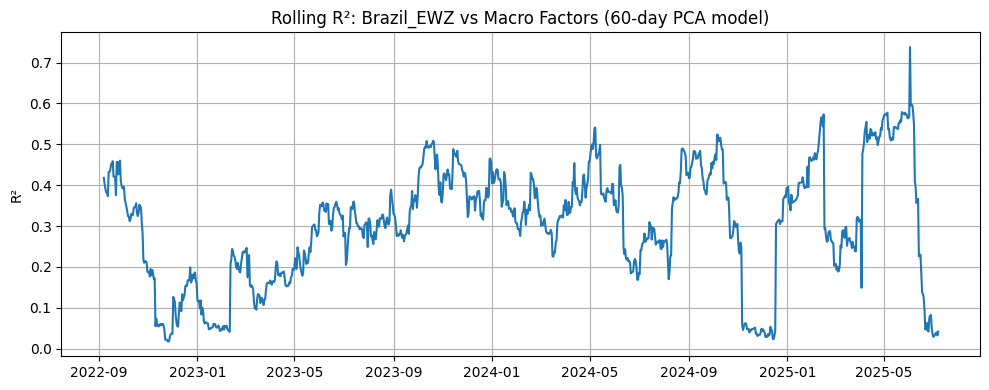

In [2]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

df = pd.read_csv('../data/combined_em_macro_data.txt', parse_dates=['date'], index_col='date')
log_returns = np.log(df / df.shift(1)).dropna()

em_cols = [c for c in df.columns if c.startswith(('Brazil', 'India', 'China', 'SouthAfrica', 'Mexico', 'Indonesia'))]
macro_cols = [c for c in df.columns if c not in em_cols]

Y_all = log_returns[em_cols]
X_all = log_returns[macro_cols]

def rolling_r2_scores(X, Y, window=60, n_components=3):
    results = pd.DataFrame(index=Y.index[window:], columns=Y.columns)
    for col in Y.columns:
        for i in range(window, len(Y)):
            X_window = X.iloc[i - window:i]
            Y_window = Y[col].iloc[i - window:i]

            scaler = StandardScaler()
            X_scaled = scaler.fit_transform(X_window)
            pca = PCA(n_components=n_components)
            X_pca = pca.fit_transform(X_scaled)

            model = LinearRegression().fit(X_pca, Y_window)
            results.at[Y_window.index[-1], col] = model.score(X_pca, Y_window)

    return results.astype(float)

rolling_r2 = rolling_r2_scores(X_all, Y_all, window=60)

sample_col = 'Brazil_EWZ'
plt.figure(figsize=(10, 4))
plt.plot(rolling_r2.index, rolling_r2[sample_col])
plt.title(f'Rolling R²: {sample_col} vs Macro Factors (60-day PCA model)')
plt.ylabel('R²')
plt.grid(True)
plt.tight_layout()
plt.show()


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Simulated example to create a rolling_r2 DataFrame
dates = pd.date_range(start="2022-01-01", periods=100, freq="B")
countries = ['Brazil_EWZ', 'India_NIFTY', 'China_CSI300', 'SouthAfrica_JSE', 'Mexico_MXX', 'Indonesia_JKSE']
rolling_r2 = pd.DataFrame(
    np.random.rand(100, len(countries)),
    index=dates,
    columns=countries
)

# Output directory
output_dir = "../output/plots"
os.makedirs(output_dir, exist_ok=True)

# Generate and save one chart per country
for col in rolling_r2.columns:
    plt.figure(figsize=(10, 4))
    plt.plot(rolling_r2.index, rolling_r2[col])
    plt.title(f'Rolling R²: {col} vs Macro Factors (60-day PCA model)')
    plt.ylabel('R²')
    plt.grid(True)
    plt.tight_layout()

    # Save plot
    filename = f"rolling_r2_{col.replace('/', '_').replace(' ', '_')}.png"
    plt.savefig(os.path.join(output_dir, filename))
    plt.close()

output_dir

'../output/plots'